In [40]:
!pip install nltk sastrawi

In [41]:
# Mengimpor pustaka yang diperlukan untuk pemrosesan teks dan pengolahan data
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import seaborn as sns

In [42]:
# Mengunduh sumber daya NLTK yang diperlukan
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
# Membaca dataset input
df = pd.read_excel('/content/ABSA_db_kalimat_komentar.xlsx')  # Ganti dengan path dataset yang sesuai
df.head()

,no,nama,kalimat,ponpes
0,1,Ainame,"Masya Allah, santri PPM Al-Ikhlash turut menye...",PPM AL-Ikhlash Lampoko
1,2,Ainame,Pemimpin Pondok Al-Ikhlash dengan keren meneri...,PPM AL-Ikhlash Lampoko
2,3,Ainame,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik...",PPM AL-Ikhlash Lampoko
3,4,Ainame,"Semangat, anak sholeh Ummi. Semoga dimudahkan ...",PPM AL-Ikhlash Lampoko
4,5,Ainame,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz...",PPM AL-Ikhlash Lampoko


In [44]:
df = df[['kalimat']]
df.head()

,kalimat
0,"Masya Allah, santri PPM Al-Ikhlash turut menye..."
1,Pemimpin Pondok Al-Ikhlash dengan keren meneri...
2,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik..."
3,"Semangat, anak sholeh Ummi. Semoga dimudahkan ..."
4,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz..."


In [45]:
# Pembersihan Data: Menghapus URL, angka, emotikon, dan karakter non-ASCII
def text_cleaning(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Mengubah semua teks menjadi huruf kecil (Case Folding)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Menghapus URL
    text = re.sub(r'\b\d+\b', '', text)  # Menghapus angka
    text = re.sub(r'[:;=]-?[)(DP]', '', text)  # Menghapus emotikon
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus tanda baca selain huruf dan spasi
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Menghapus karakter non-ASCII
    return text

In [46]:
# Normalisasi slang menggunakan kamus khusus
def normalize_slang(text, slang_dict):
    if not isinstance(text, str):
        return ""
    return ' '.join([slang_dict.get(word, word) for word in text.split()])  # Mengganti slang dengan bentuk yang normal

In [47]:
# Stemming menggunakan Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text, stemmer):
    if not isinstance(text, str):
        return ""
    return stemmer.stem(text)

In [48]:
# Menghapus stopword
def remove_stopwords_text(text, stopwords_set):
    if not isinstance(text, str):
        return ""
    return ' '.join([word for word in text.split() if word not in stopwords_set])  # Menghapus kata yang ada di daftar stopword

In [49]:
# Memuat kamus slang
slang_dict1 = pd.read_excel('/content/SlangwordAFJ.xlsx')
slang_dict2 = pd.read_excel('/content/slangword_pujangga.xlsx')
slang_dict3 = pd.read_excel('/content/slangword_ramaprakoso.xlsx')

# Menggabungkan kamus slang dan menghapus duplikasi
slang_all = pd.concat([slang_dict1, slang_dict2, slang_dict3], ignore_index=True)
slang_all.drop_duplicates(subset='sebelum', keep='last', inplace=True)
slang_dict = dict(zip(slang_all['sebelum'], slang_all['sesudah']))  # Membuat kamus untuk normalisasi slang

In [50]:
# **Proses Data**: Melakukan pembersihan data, case folding, normalisasi slang, stopword removal, dan stemming
df['cleaned_text'] = df['kalimat'].fillna("").apply(text_cleaning)  # Kolom 'content' pada df
df.head()

,kalimat,cleaned_text
0,"Masya Allah, santri PPM Al-Ikhlash turut menye...",masya allah santri ppm alikhlash turut menyera...
1,Pemimpin Pondok Al-Ikhlash dengan keren meneri...,pemimpin pondok alikhlash dengan keren menerim...
2,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik...",sehat selalu pak ustaz aamiin pemimpin alikhla...
3,"Semangat, anak sholeh Ummi. Semoga dimudahkan ...",semangat anak sholeh ummi semoga dimudahkan da...
4,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz...",masya allah alhamdulillah ananda muhammad dzak...


In [51]:
df['normalized_text'] = df['cleaned_text'].apply(lambda x: normalize_slang(x, slang_dict))  # Normalisasi slang
df.head()

,kalimat,cleaned_text,normalized_text
0,"Masya Allah, santri PPM Al-Ikhlash turut menye...",masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash turut menyera...
1,Pemimpin Pondok Al-Ikhlash dengan keren meneri...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash dengan keren menerim...
2,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik...",sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat selalu pak ustaz aamiin pemimpin alikhla...
3,"Semangat, anak sholeh Ummi. Semoga dimudahkan ...",semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan da...
4,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz...",masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...


In [52]:
indo_stopwords = set(stopwords.words('indonesian'))
df['stopword'] = df['normalized_text'].apply(lambda x: remove_stopwords_text(x, indo_stopwords))  # Menghapus stopword
df.head()

,kalimat,cleaned_text,normalized_text,stopword
0,"Masya Allah, santri PPM Al-Ikhlash turut menye...",masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash menyerahkan b...
1,Pemimpin Pondok Al-Ikhlash dengan keren meneri...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash keren menerima kunju...
2,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik...",sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat ustaz aamiin pemimpin alikhlash menerima...
3,"Semangat, anak sholeh Ummi. Semoga dimudahkan ...",semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan di...
4,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz...",masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...


In [53]:
df['stemmed_text'] = df['stopword'].apply(lambda x: stem_text(x, stemmer))  # Stemming
df.head()

,kalimat,cleaned_text,normalized_text,stopword,stemmed_text
0,"Masya Allah, santri PPM Al-Ikhlash turut menye...",masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash menyerahkan b...,masya allah santri ppm alikhlash serah bantu k...
1,Pemimpin Pondok Al-Ikhlash dengan keren meneri...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash keren menerima kunju...,pimpin pondok alikhlash keren terima kunjung u...
2,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik...",sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat ustaz aamiin pemimpin alikhlash menerima...,sehat ustaz aamiin pimpin alikhlash terima kun...
3,"Semangat, anak sholeh Ummi. Semoga dimudahkan ...",semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan di...,semangat anak sholeh ummi moga mudah lancar al...
4,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz...",masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...


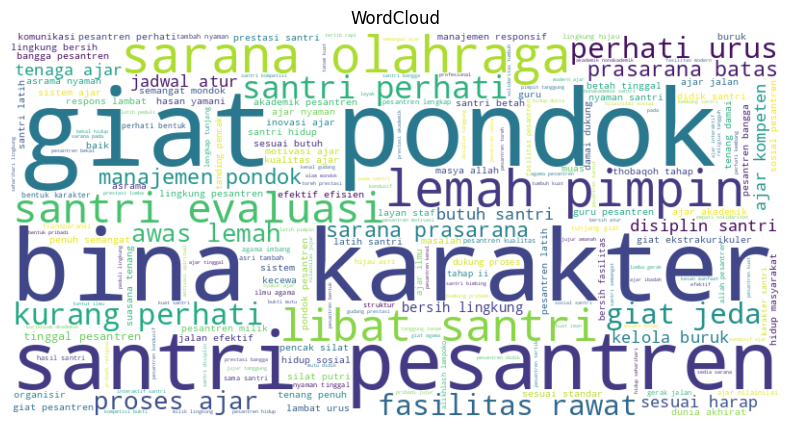

In [54]:
# WordCloud
all_text = ' '.join(df['stemmed_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud")
plt.show()

In [55]:
# Tokenizing Unigram dan Ekstraksi Fitur TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))  # Unigram
X_tfidf = vectorizer.fit_transform(df['stemmed_text'])  # Mengubah teks menjadi fitur TF-IDF

# Visualisasi matriks TF-IDF
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print("\nContoh Matriks TF-IDF: ")
tfidf_df.head()


Contoh Matriks TF-IDF: 


,aaaaaamin,aaaaamin,aah,aalamiin,aamiiiin,aamiiin,aamiin,aamiinn,aamin,abdi,...,yoyo,yra,yuyun,zahra,zaid,zainuddin,zaki,ziarah,zulkifli,zulkifly
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.207054,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Load the tokenizer and model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("taufiqdp/indonesian-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("taufiqdp/indonesian-sentiment")

# Define the class names based on the new model's output
class_names = ['negatif', 'netral', 'positif']

# Function to perform sentiment labeling
def label_sentiment(text):
    if not text.strip():  # Check if the text is empty or just whitespace
        return 'negatif'  # If the text is empty, consider it as 'negatif' (this can be adjusted based on requirements)

    # Tokenize the text
    tokenized_text = tokenizer(text, return_tensors='pt')

    # Perform sentiment classification using the model
    with torch.no_grad():  # Disable gradients during inference
        logits = model(**tokenized_text)['logits']  # Get the logits (model's raw output)

    # Get the class with the highest probability (argmax)
    result = class_names[logits.argmax(dim=1).item()]  # Select the label with the highest logit value

    return result

# Apply the sentiment labeling function after text preprocessing (cleaning, stopword removal, stemming)
df['predicted_label'] = df['stemmed_text'].apply(label_sentiment)

# Display the results
df.head()

,kalimat,cleaned_text,normalized_text,stopword,stemmed_text,predicted_label
0,"Masya Allah, santri PPM Al-Ikhlash turut menye...",masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash turut menyera...,masya allah santri ppm alikhlash menyerahkan b...,masya allah santri ppm alikhlash serah bantu k...,netral
1,Pemimpin Pondok Al-Ikhlash dengan keren meneri...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash dengan keren menerim...,pemimpin pondok alikhlash keren menerima kunju...,pimpin pondok alikhlash keren terima kunjung u...,positif
2,"Sehat selalu Pak Ustaz, aamiin. Pemimpin Al-Ik...",sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat selalu pak ustaz aamiin pemimpin alikhla...,sehat ustaz aamiin pemimpin alikhlash menerima...,sehat ustaz aamiin pimpin alikhlash terima kun...,netral
3,"Semangat, anak sholeh Ummi. Semoga dimudahkan ...",semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan da...,semangat anak sholeh ummi semoga dimudahkan di...,semangat anak sholeh ummi moga mudah lancar al...,positif
4,"Masya Allah, Alhamdulillah. Ananda Muhammad Dz...",masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...,masya allah alhamdulillah ananda muhammad dzak...,netral


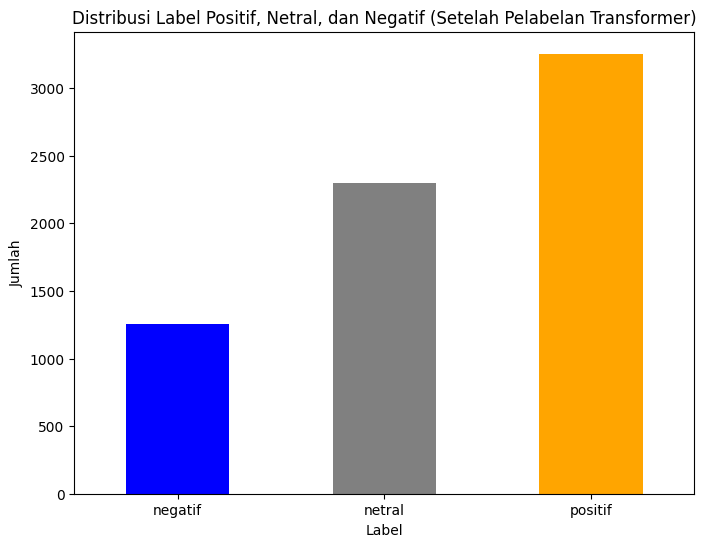

In [57]:
# Sort the value counts based on the label order: Negative, Neutral, Positive
label_order = ['negatif', 'netral', 'positif']
label_counts_after_labeling = df['predicted_label'].value_counts().reindex(label_order, fill_value=0)

# Plot the bar chart with the custom label order
plt.figure(figsize=(8, 6))
label_counts_after_labeling.plot(kind='bar', color=['blue', 'grey', 'orange'])
plt.title('Distribusi Label Positif, Netral, dan Negatif (Setelah Pelabelan Transformer)')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

In [58]:
# **Tanpa SMOTE**: Memisahkan Dataset menjadi Training dan Testing (80%-20%) tanpa SMOTE
X_train_no_smote, X_test_no_smote, y_train_no_smote, y_test_no_smote = train_test_split(X_tfidf, df['predicted_label'], test_size=0.2, random_state=42)

In [59]:
# Definisikan label classes
classes = sorted(list(set(y_test_no_smote)))  # Menentukan label classes (misal: 'negatif', 'netral', 'positif')
n_classes = len(classes)  # Menentukan jumlah classes

# Binarisasi label untuk ROC-AUC
y_test_bin_no_smote = label_binarize(y_test_no_smote, classes=classes)

# Warna untuk plot ROC
colors = cycle(['blue', 'green', 'orange'])

In [60]:
# ==================== Model SVM Linear ====================
print("=== Model SVM Linear ===")
# Pelatihan Model SVM Linear
classifier_linear = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))  # SVM dengan kernel Linear
classifier_linear.fit(X_train_no_smote, y_train_no_smote)  # Melatih model
y_pred_linear = classifier_linear.predict(X_test_no_smote)  # Memprediksi kelas
y_score_linear = classifier_linear.predict_proba(X_test_no_smote)  # Memprediksi probabilitas classes

# Classification Report untuk SVM Linear
print("Classification Report SVM Linear:")
print(classification_report(y_test_no_smote, y_pred_linear))

=== Model SVM Linear ===
Classification Report SVM Linear:
              precision    recall  f1-score   support

     negatif       0.93      0.92      0.92       251
      netral       0.93      0.93      0.93       474
     positif       0.95      0.95      0.95       637

    accuracy                           0.94      1362
   macro avg       0.94      0.93      0.93      1362
weighted avg       0.94      0.94      0.94      1362



In [61]:
print("=== Model SVM RBF ===")
# Pelatihan Model SVM RBF
classifier_rbf = OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=42))  # SVM dengan kernel RBF
classifier_rbf.fit(X_train_no_smote, y_train_no_smote)  # Melatih model
y_pred_rbf = classifier_rbf.predict(X_test_no_smote)  # Memprediksi kelas
y_score_rbf = classifier_rbf.predict_proba(X_test_no_smote)  # Memprediksi probabilitas classes

# Classification Report untuk SVM RBF
print("Classification Report SVM RBF:")
print(classification_report(y_test_no_smote, y_pred_rbf))

=== Model SVM RBF ===
Classification Report SVM RBF:
              precision    recall  f1-score   support

     negatif       0.94      0.92      0.93       251
      netral       0.91      0.92      0.92       474
     positif       0.94      0.94      0.94       637

    accuracy                           0.93      1362
   macro avg       0.93      0.93      0.93      1362
weighted avg       0.93      0.93      0.93      1362



In [62]:
# ==================== Model SVM Polynomial ====================
print("=== Model SVM Polynomial ===")
# Pelatihan Model SVM Polynomial
classifier_poly = OneVsRestClassifier(SVC(kernel='poly', probability=True, random_state=42))  # SVM dengan kernel Polynomial
classifier_poly.fit(X_train_no_smote, y_train_no_smote)  # Melatih model
y_pred_poly = classifier_poly.predict(X_test_no_smote)  # Memprediksi kelas
y_score_poly = classifier_poly.predict_proba(X_test_no_smote)  # Memprediksi probabilitas classes

# Classification Report untuk SVM Polynomial
print("Classification Report SVM Polynomial:")
print(classification_report(y_test_no_smote, y_pred_poly))

=== Model SVM Polynomial ===


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-62-836207059>", line 5, in <cell line: 0>
    classifier_poly.fit(X_train_no_smote, y_train_no_smote)  # Melatih model
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py", line 376, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/parallel.py", line 77, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^

TypeError: object of type 'NoneType' has no len()

In [ ]:
# Confusion Matrix untuk SVM Linear
cm_linear = confusion_matrix(y_test_no_smote, y_pred_linear, labels=classes)
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix SVM Linear')
plt.xlabel('Prediksi')
plt.ylabel('Nilai Sebenarnya')
plt.show()

In [ ]:
# Confusion Matrix untuk SVM RBF
cm_rbf = confusion_matrix(y_test_no_smote, y_pred_rbf, labels=classes)
sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix SVM RBF')
plt.xlabel('Prediksi')
plt.ylabel('Nilai Sebenarnya')
plt.show()

In [ ]:
# Confusion Matrix untuk SVM Polynomial
cm_poly = confusion_matrix(y_test_no_smote, y_pred_poly, labels=classes)
sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix SVM Polynomial')
plt.xlabel('Prediksi')
plt.ylabel('Nilai Sebenarnya')
plt.show()

In [ ]:
# Hitung ROC dan AUC untuk tiap classes (Linear)
fpr_linear = dict()
tpr_linear = dict()
roc_auc_linear = dict()
for i in range(n_classes):
    fpr_linear[i], tpr_linear[i], _ = roc_curve(y_test_bin_no_smote[:, i], y_score_linear[:, i])  # Menghitung FPR dan TPR
    roc_auc_linear[i] = auc(fpr_linear[i], tpr_linear[i])  # Menghitung AUC

# Plot ROC untuk SVM Linear
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_linear[i], tpr_linear[i], color=color, lw=2, label=f'ROC Linear classes {classes[i]} (AUC = {roc_auc_linear[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — SVM Linear (Multiclass)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Hitung ROC dan AUC untuk tiap classes (RBF)
fpr_rbf = dict()
tpr_rbf = dict()
roc_auc_rbf = dict()
for i in range(n_classes):
    fpr_rbf[i], tpr_rbf[i], _ = roc_curve(y_test_bin_no_smote[:, i], y_score_rbf[:, i])  # Menghitung FPR dan TPR
    roc_auc_rbf[i] = auc(fpr_rbf[i], tpr_rbf[i])  # Menghitung AUC

# Plot ROC untuk SVM RBF
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rbf[i], tpr_rbf[i], color=color, lw=2, linestyle='--', label=f'ROC RBF classes {classes[i]} (AUC = {roc_auc_rbf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — SVM RBF (Multiclass)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# Hitung ROC dan AUC untuk tiap classes (Polynomial)
fpr_poly = dict()
tpr_poly = dict()
roc_auc_poly = dict()
for i in range(n_classes):
    fpr_poly[i], tpr_poly[i], _ = roc_curve(y_test_bin_no_smote[:, i], y_score_poly[:, i])  # Menghitung FPR dan TPR
    roc_auc_poly[i] = auc(fpr_poly[i], tpr_poly[i])  # Menghitung AUC

# Plot ROC untuk SVM Polynomial
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_poly[i], tpr_poly[i], color=color, lw=2, linestyle=':', label=f'ROC Polynomial classes {classes[i]} (AUC = {roc_auc_poly[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — SVM Polynomial (Multiclass)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# **Menggunakan SMOTE untuk Oversampling**
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, df['predicted_label'])  # Menggunakan data TF-IDF untuk SMOTE

In [ ]:
# Hitung distribusi sebelum dan sesudah SMOTE
original_counts = df['predicted_label'].value_counts().sort_index()
smote_counts = pd.Series(y_smote).value_counts().sort_index()
added_counts = smote_counts - original_counts

# Buat DataFrame untuk stacked bar plot
df_plot = pd.DataFrame({
    'Sebelum SMOTE': original_counts,
    'Tambahan Data': added_counts
})

# Plot stacked bar chart
ax = df_plot.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], figsize=(10,8))

# Tambahkan label jumlah di dalam bar
for i, (ori, add) in enumerate(zip(original_counts, added_counts)):
    ax.text(i, ori/2, str(ori), color='white', ha='center', va='center', fontweight='bold')
    ax.text(i, ori + add/2, str(add), color='white', ha='center', va='center', fontweight='bold')

plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Jumlah Data Berdasarkan Label Sebelum dan Sesudah SMOTE')
plt.legend(loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# **Memisahkan Dataset menjadi Training dan Testing (80%-20%)**
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

In [ ]:
# **Support Vector Machine (SVM)**
svm = SVC(kernel='linear', random_state=42)  # Menggunakan kernel linear untuk SVM
svm.fit(X_train, y_train)  # Melatih model SVM dengan data pelatihan
y_pred_svm = svm.predict(X_test)  # Memprediksi hasil
print("Laporan Klasifikasi dengan SVM:")
print(classification_report(y_test, y_pred_svm))  # Menampilkan laporan klasifikasi untuk SVM

In [ ]:
# Model SVM dengan kernel RBF
svm_rbf = SVC(kernel='rbf', random_state=42)  # Menggunakan kernel RBF untuk SVM
svm_rbf.fit(X_train, y_train)  # Melatih model SVM dengan kernel RBF
y_pred_rbf = svm_rbf.predict(X_test)  # Memprediksi hasil
print("Laporan Klasifikasi dengan SVM (Kernel RBF):")
print(classification_report(y_test, y_pred_rbf))  # Menampilkan laporan klasifikasi untuk SVM dengan kernel RBF

In [ ]:
# Model SVM dengan kernel Polynomial
svm_poly = SVC(kernel='poly', random_state=42)  # Menggunakan kernel Polynomial untuk SVM
svm_poly.fit(X_train, y_train)  # Melatih model SVM dengan kernel Polynomial
y_pred_poly = svm_poly.predict(X_test)  # Memprediksi hasil
print("Laporan Klasifikasi dengan SVM (Kernel Polynomial):")
print(classification_report(y_test, y_pred_poly))  # Menampilkan laporan klasifikasi untuk SVM dengan kernel Polynomial

In [ ]:
# Label string sesuai isi y_test dan y_pred
label_names = ['negatif', 'netral', 'positif']

# Hitung confusion matrix
cm_linear = confusion_matrix(y_test, y_pred_svm, labels=label_names)
cm_rbf    = confusion_matrix(y_test, y_pred_rbf,  labels=label_names)
cm_poly   = confusion_matrix(y_test, y_pred_poly, labels=label_names)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names, ax=axes[0])
axes[0].set_title('SVM Linear')
axes[0].set_xlabel('Prediksi')
axes[0].set_ylabel('Nilai Sebenarnya')

sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=False, ax=axes[1])
axes[1].set_title('SVM RBF')
axes[1].set_xlabel('Prediksi')

sns.heatmap(cm_poly, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=False, ax=axes[2])
axes[2].set_title('SVM Polynomial')
axes[2].set_xlabel('Prediksi')

plt.tight_layout()
plt.show()


In [ ]:
# Label kelas (misal: 3 kelas)
classes = sorted(list(set(y_test)))  # [0, 1, 2] atau ['Negatif', ...]
n_classes = len(classes)

# Binarize label untuk ROC-AUC
y_test_bin = label_binarize(y_test, classes=classes)

# ==================== Model SVM Linear ROC ====================
classifier = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
classifier.fit(X_train, label_binarize(y_train, classes=classes))
y_score = classifier.predict_proba(X_test)

# Hitung ROC dan AUC untuk tiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Multiclass
colors = cycle(['blue', 'green', 'orange'])
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC kelas {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — SVM Linear (Multiclass)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# === SVM RBF ===
classifier_rbf = OneVsRestClassifier(SVC(kernel='rbf', probability=True, random_state=42))
classifier_rbf.fit(X_train, y_train)
y_score_rbf = classifier_rbf.predict_proba(X_test)

# ROC & AUC
fpr_rbf, tpr_rbf, roc_auc_rbf = dict(), dict(), dict()
for i in range(n_classes):
    fpr_rbf[i], tpr_rbf[i], _ = roc_curve(y_test_bin[:, i], y_score_rbf[:, i])
    roc_auc_rbf[i] = auc(fpr_rbf[i], tpr_rbf[i])

# Plot
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rbf[i], tpr_rbf[i], color=color, lw=2,
             label=f'ROC kelas {classes[i]} (AUC = {roc_auc_rbf[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve — SVM RBF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# === SVM Polynomial ===
classifier_poly = OneVsRestClassifier(SVC(kernel='poly', probability=True, random_state=42))
classifier_poly.fit(X_train, y_train)
y_score_poly = classifier_poly.predict_proba(X_test)

# ROC & AUC
fpr_poly, tpr_poly, roc_auc_poly = dict(), dict(), dict()
for i in range(n_classes):
    fpr_poly[i], tpr_poly[i], _ = roc_curve(y_test_bin[:, i], y_score_poly[:, i])
    roc_auc_poly[i] = auc(fpr_poly[i], tpr_poly[i])

# Plot
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_poly[i], tpr_poly[i], color=color, lw=2,
             label=f'ROC kelas {classes[i]} (AUC = {roc_auc_poly[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve — SVM Polynomial')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
